## Is it AI?

In [58]:
!pip install -U ddgs

In [59]:
!pip install -Uqq fastai 'duckduckgo_search>=6.2'

## Step 1: Download images of human faces and AI-generated faces

In [60]:
from ddgs import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

In [61]:
urls = search_images('ai generated face', max_images=1)
urls[0]

'https://media.theresanaiforthat.com/realistic-human-face-generator@2881090.png?width=1000'

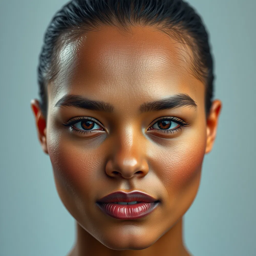

In [62]:
from fastdownload import download_url
dest = 'ai_face.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching images for human faces:

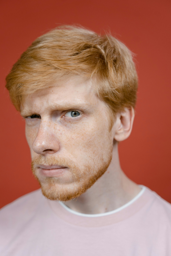

In [63]:
download_url(search_images('stock photo of a person', max_images=1)[0], 'human_face.jpg', show_progress=False)
Image.open('human_face.jpg').to_thumb(256,256)

In [71]:
searches = ['stock photo of a person','ai generated person']
labels = ['human', 'ai']
path = Path('ai_or_not')

for o, label in zip(searches, labels):
  dest = (path/label)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  time.sleep(5)
  resize_images(dest, max_size=400, dest=dest)

## Step 2: Train the model

Checking for failure in training

In [72]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

DataBlock which stores data for image classification

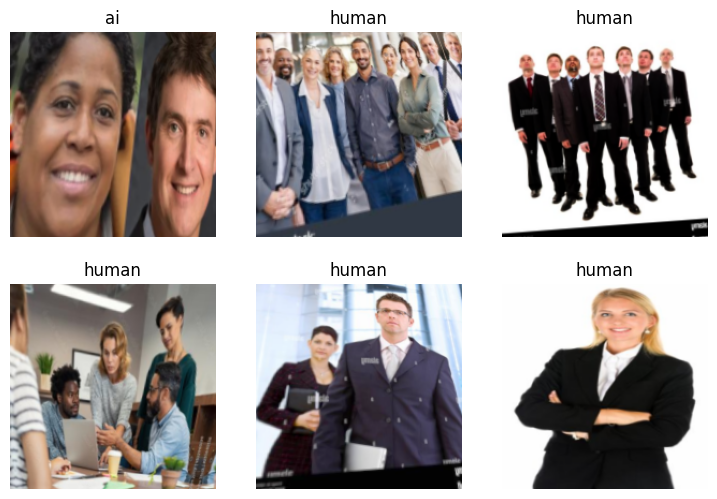

In [73]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms()  #Data Augumentation
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

We will use **resnet18** model

In [74]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.903711,0.376057,0.157534,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.378187,0.351434,0.123288,00:03
1,0.258262,0.153119,0.047945,00:03
2,0.168342,0.110011,0.020548,00:04


## Step 3: Cleaning the model

In [75]:
from fastai.vision.widgets import *

In [76]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [77]:
for i in cleaner.delete():
  cleaner.fns[i].unlink()

for i, ai in cleaner.change():
    src = Path(cleaner.fns[i])
    dest = path/ai/src.name
    if not dest.exists():
        shutil.move(str(src), str(dest))

for i, human in cleaner.change():
    src = Path(cleaner.fns[i])
    dest = path/human/src.name
    if not dest.exists():
        shutil.move(str(src), str(dest))

## Step 4: Using the model

Testing the model with an image of a human:

tensor([0.0020, 0.9980])
['ai', 'human']
This is a: human.
Confidence: 0.9980


<Axes: title={'center': 'human (0.9980)'}>

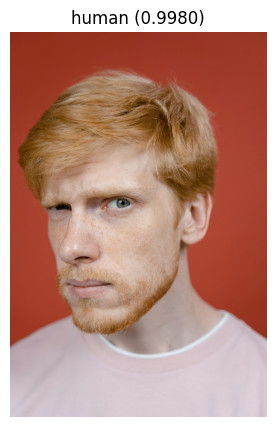

In [78]:
is_ai, idx, probs = learn.predict(PILImage.create('human_face.jpg'))
print(probs)
print(learn.dls.vocab)
print(f"This is a: {is_ai}.")
print(f"Confidence: {probs[idx]:.4f}")
PILImage.create('human_face.jpg').show(title=f"{is_ai} ({probs[idx]:.4f})")

##Step 5: Classification Matrix

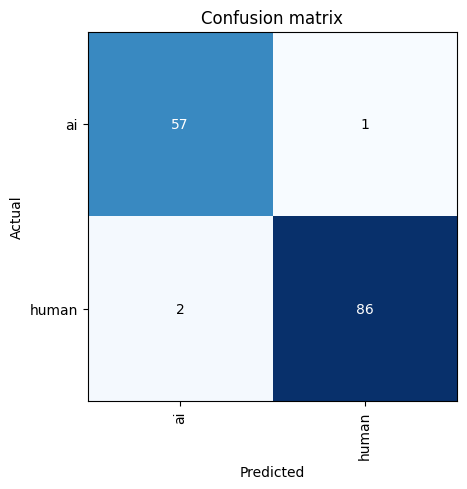

In [80]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()